CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device('cuda' if cuda else 'cpu')
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 128

if torch.cuda.is_available():
    kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [6]:
len(train_loader), len(test_loader),  len(train_data), len(test_data)

(469, 79, 60000, 10000)

In [7]:
len(train_data)/len(train_loader), len(test_data)/len(test_loader)

(127.9317697228145, 126.58227848101266)

CODE BLOCK: 6

C:\Users\muthu\AppData\Local\Temp\ipykernel_19368\695351802.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


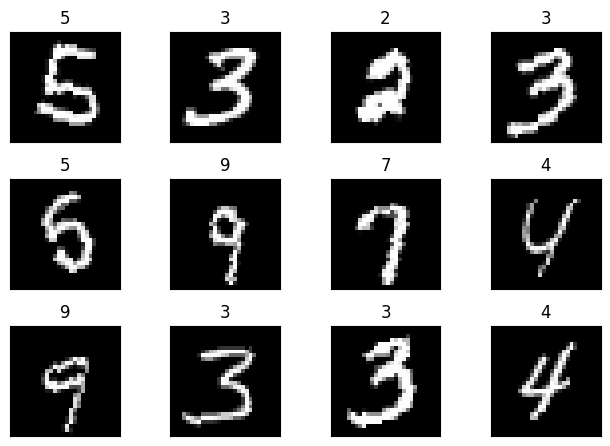

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])
plt.show()

CODE BLOCK: 7

In [9]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))                  # 28>26    | 1>3     | 1>1 
        x = F.relu(F.max_pool2d(self.conv2(x),2))  # 26>24>12 | 3>5>6   | 1>1>2
        x = F.relu(self.conv3(x))                  # 12>10    | 6>10    | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x),2))  # 10>8>4   | 10>14>16| 2>2>4
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [11]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [12]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0836 Batch_id=468 Accuracy=85.92: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]


Test set: Average loss: 0.0630, Accuracy: 9797/10000 (97.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1026 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:09<00:00, 48.14it/s]


Test set: Average loss: 0.0374, Accuracy: 9877/10000 (98.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0460 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:09<00:00, 49.23it/s]


Test set: Average loss: 0.0312, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0283 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 49.01it/s]


Test set: Average loss: 0.0326, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0148 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:09<00:00, 49.32it/s]


Test set: Average loss: 0.0269, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0556 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:09<00:00, 48.91it/s]


Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0334 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:09<00:00, 49.38it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0136 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:09<00:00, 49.69it/s]


Test set: Average loss: 0.0195, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0979 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:09<00:00, 48.88it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0235 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:09<00:00, 49.43it/s]


Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0101 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:09<00:00, 49.21it/s]


Test set: Average loss: 0.0189, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0023 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:09<00:00, 49.58it/s]


Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0036 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:09<00:00, 49.48it/s]


Test set: Average loss: 0.0207, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0016 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:09<00:00, 49.27it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0278 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:09<00:00, 49.26it/s]


Test set: Average loss: 0.0240, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0038 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:09<00:00, 49.32it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0217 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:09<00:00, 49.31it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0202 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:09<00:00, 49.15it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0095 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0096 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:10<00:00, 44.99it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

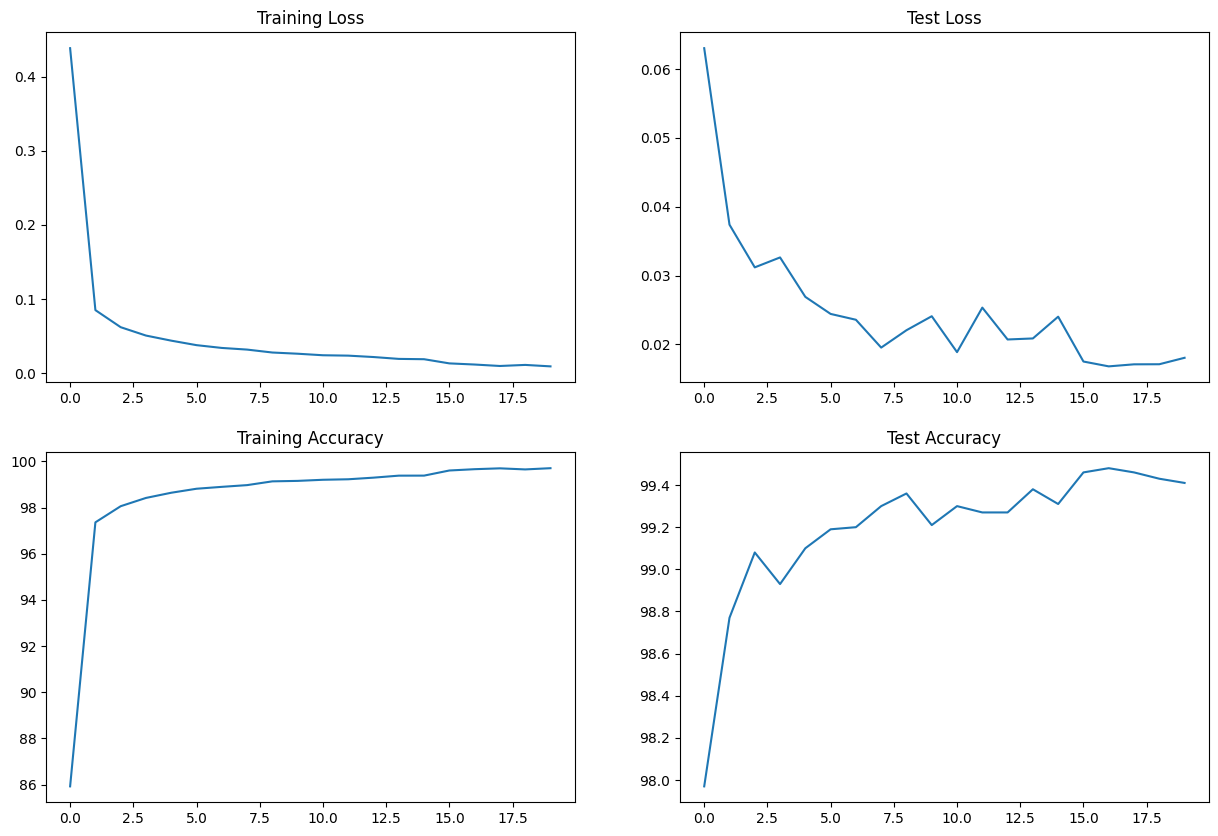

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()